# Linear Models
## with missing data imputed

In [1]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, MLBase
# LassoPlot is not working with the other updated packages

In [2]:
include("../plot_pred.jl")

plot_pred_true (generic function with 2 methods)

In [79]:
df = CSV.read("../data collection/weekly_ff_elo.csv", DataFrame, missingstring = "NA")

feature_names = names(df)
for i in 1:size(df, 2)
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Int64
6	PassingTD			Int64
7	Int			Int64
8	PassingAtt			Int64
9	Cmp			Int64
10	RushingAtt			Int64
11	RushingYds			Int64
12	RushingTD			Int64
13	Rec			Int64
14	Tgt			Int64
15	ReceivingYds			Int64
16	ReceivingTD			Int64
17	FL			Int64
18	PPRFantasyPoints			Float64
19	StandardFantasyPoints			Float64
20	HalfPPRFantasyPoints			Float64
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_cum			Float64
36	Tgt_cum			Float64
37	ReceivingYds_cum			Float64
38	ReceivingTD_cum			Float64
39	FL_cum			Float64
40	team1_score_cum			Float64
41	team2_score_cum			Float64
42	PassingYds_prev			Int64
43	PassingTD_prev			Int64
44	Int_prev			Int64
45	PassingAt

In [80]:
Random.seed!(0)

# df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 52782


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,5,Nate Washington,WR,TEN,0,0,0,0
2,2,Quincy Enunwa,WR,NYJ,0,0,0,0
3,16,Randy McMichael,TE,STL,0,0,0,0
4,11,Mychal Rivera,TE,OAK,0,0,0,0
5,17,Matt Moore,QB,CAR,162,1,0,23
6,4,Jason Avant,WR,PHI,0,0,0,0
7,1,Tarvaris Jackson,QB,MIN,0,0,0,1
8,4,Dak Prescott,QB,DAL,223,0,1,33
9,13,T.J. Yeldon,RB,JAX,0,0,0,0


In [81]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev,
    :elo1_pre,
    :elo2_pre
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real];

In [82]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

In [61]:
names(train_x)

55-element Array{String,1}:
 "week"
 "Player"
 "Pos"
 "team1"
 "team2"
 "type"
 "game_id"
 "PassingYds"
 "PassingTD"
 "Int"
 "PassingAtt"
 "Cmp"
 "RushingAtt"
 ⋮
 "RushingAtt_prev"
 "RushingYds_prev"
 "RushingTD_prev"
 "Rec_prev"
 "Tgt_prev"
 "ReceivingYds_prev"
 "ReceivingTD_prev"
 "FL_prev"
 "team1_score_prev"
 "team2_score_prev"
 "elo1_pre"
 "elo2_pre"

In [64]:
for col in names(train_x)[7:end]
    train_x[ismissing.(train_x[:,col]), col] .= 0
end
for col in names(test_x)[7:end]
    test_x[ismissing.(test_x[:,col]), col] .= 0
end

In [83]:
train_x_matrix = replace(convert(Matrix, train_x), missing => 0);
test_x_matrix = replace(convert(Matrix, test_x), missing => 0);

In [53]:
train_x

,week,Player,Pos,team1,team2,type,game_id,PassingYds
,Int64,String,String?,String,String,String,Int64,Int64?
1,17,Jacquizz Rodgers,RB,TAM,ATL,reg,2018123010,0
2,17,Jimmy Garoppolo,QB,NWE,BUF,reg,2014122807,90
3,12,Jesse James,TE,DET,WAS,reg,2019112407,0
4,6,Jermaine Gresham,TE,CIN,CLE,reg,2012101403,0
5,5,Gary Barnidge,TE,CLE,NWE,reg,2016100901,0
6,3,Jonathan Grimes,RB,HOU,NWE,reg,2016092200,0
7,12,Cody Core,WR,CIN,CLE,reg,2018112503,0
8,8,Jeromey Clary,RT,SDG,CLE,reg,2012102802,0
9,16,Ricardo Lockette,WR,SEA,SFO,reg,2011122412,0


In [84]:
cat_labels = [
  :team1,
  :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [85]:
train_std = replace(train_std, missing => 0)
test_std = replace(test_std, missing => 0)

train_ppr = replace(train_ppr, missing => 0)
test_ppr = replace(test_ppr, missing => 0)

train_half = replace(train_half, missing => 0)
test_half = replace(test_half, missing => 0);

In [90]:
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals), missing => 0)
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals), missing => 0)

10557×189 Array{Float64,2}:
   0.0    0.0      0.0        0.0     …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 317.667  2.16667  0.666667  36.6667     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0     …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 241.0    1.28571  1.42857   33.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0     …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        0.0  0.0  0.0  0.0  0.0  0.0  0

In [91]:
m = lm(Xtrain, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────────────────
            Coef.     Std. Error       t  Pr(>|t|)      Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────
x1     0.0254661     0.00427644     5.95    <1e-8     0.0170842      0.033848
x2     1.07778       0.21594        4.99    <1e-6     0.654531       1.50102
x3    -0.257202      0.223061      -1.15    0.2489   -0.694407       0.180002
x4    -0.167115      0.0445031     -3.76    0.0002   -0.254342      -0.0798876
x5     0.251517      0.0733947      3.43    0.0006    0.107661       0.395372
x6     0.0753171     0.0295593      2.55    0.0108    0.0173803      0.133254
x7     0.0470911     0.00600046     7.85    <1e-14    0.0353301      0.0588521
x8     1.39868       0.2433         5.75    <1e-8     0.921808       1.87555
x9    -0.

In [92]:
pred_m_test = predict(m, Xtest)

10557-element Array{Float64,1}:
  2.7900537961309153
  5.89837591539856
 12.02476267462693
  3.5331808582609616
 19.392282822439675
  1.4149869532374875
  4.992543849045783
 17.084417071834558
  4.088845093018982
  3.6791769891104638
  4.584282563981418
  7.093231482166722
  4.84515475755928
  ⋮
  8.239185362757134
  8.315978302552724
  3.890027509363078
  4.99541475929563
  4.118003625679019
  3.284783623199674
  8.145770126342756
  3.923310190545518
 11.151732061723122
  8.749502561542464
  3.008005354854094
 13.250371324375045

In [93]:
test_MSE = MSE(test_std, pred_m_test)

32.13471368681976

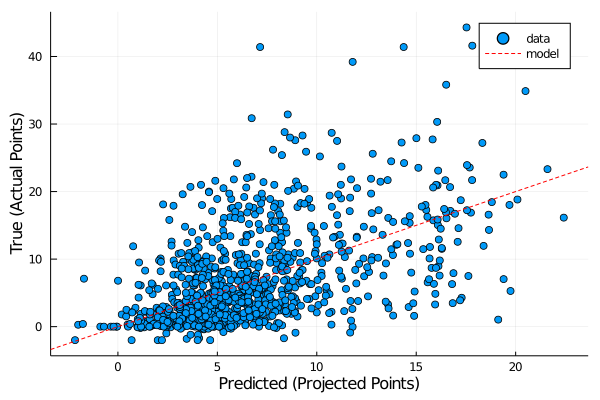

In [94]:
plot_pred_true(pred_m_test, test_std)

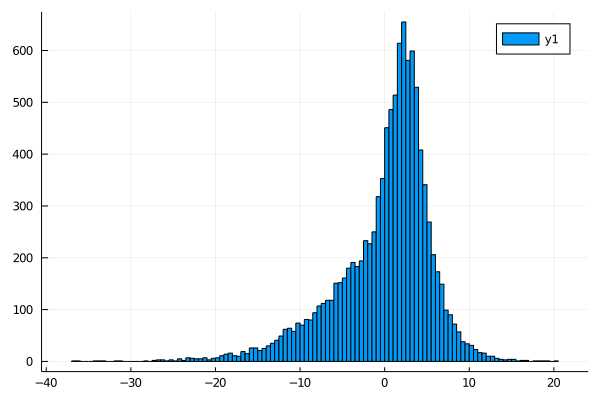

In [96]:
histogram(pred_m_test - test_std)

In [102]:
Random.seed!(0)
lasso_cv = fit(LassoModel, Xtrain, train_std; select = MinCVmse(Kfold(42195,10)), standardize = false, intercept = false);

In [104]:
pred_lasso_cv = predict(lasso_cv, Xtest)

10557-element Array{Float64,1}:
  2.882574269810681
  5.62675365917497
 11.196623955991301
  3.961507034877818
 18.862286214347833
  2.883154673960317
  4.162913093436488
 17.346659722611204
  4.330337975250657
  3.931531148799545
  4.016199470914789
  6.423138302914875
  4.311357666894574
  ⋮
  6.701346410803978
  8.33277636712596
  4.354868351784882
  3.7464904566308874
  3.7580307603988947
  3.6570774914425987
  8.260984316330124
  5.138049169393725
 10.329842522987418
  7.683221743222862
  3.81537390716821
 13.311585245806143

In [105]:
test_MSE_lasso_cv = MSE(test_std, pred_lasso_cv)

33.371145137893215

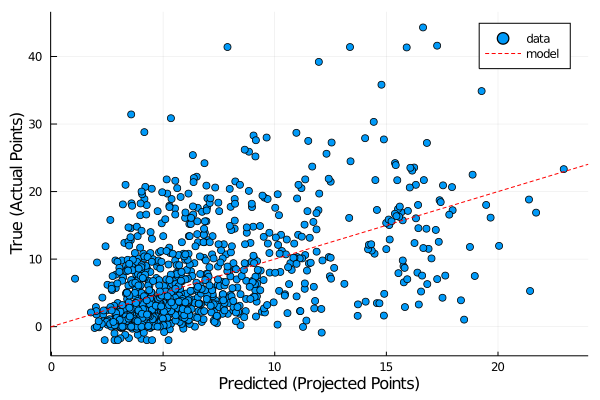

In [106]:
plot_pred_true(pred_lasso_cv, test_std)